In [1]:
import pandas_datareader.data as web

/Users/admin/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
import pandas.testing

In [3]:
import datetime

In [5]:
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2017, 1, 1)


In [9]:
facebook = web.DataReader('FB', 'yahoo', start, end)

In [10]:
facebook.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,78.930000,77.699997,78.580002,78.449997,18177500,78.449997
2015-01-05,79.250000,76.860001,77.980003,77.190002,26452200,77.190002
2015-01-06,77.589996,75.360001,77.230003,76.150002,27399300,76.150002
2015-01-07,77.360001,75.820000,76.760002,76.150002,22045300,76.150002
2015-01-08,78.230003,76.080002,76.739998,78.180000,23961000,78.180000


In [13]:
from pandas_datareader.data import Options
fb_options = Options("FB", 'yahoo')

ImmediateDeprecationError: 
Yahoo Options has been immediately deprecated due to large breaks in the API without the
introduction of a stable replacement. Pull Requests to re-enable these data
connectors are welcome.

See https://github.com/pydata/pandas-datareader/issues


In [30]:
import pandas as pd
class YahooDailyReader():
    
    def __init__(self, symbol=None, start=None, end=None):
        import datetime, time
        self.symbol = symbol
        
        # initialize start/end dates if not provided
        if end is None:
            end = datetime.datetime.today()
        if start is None:
            start = datetime.datetime(2010,1,1)
        
        self.start = start
        self.end = end
        
        # convert dates to unix time strings
        unix_start = int(time.mktime(self.start.timetuple()))
        day_end = self.end.replace(hour=23, minute=59, second=59)
        unix_end = int(time.mktime(day_end.timetuple()))
        
        url = 'https://finance.yahoo.com/quote/{}/history?'
        url += 'period1={}&period2={}'
        url += '&filter=history'
        url += '&interval=1d'
        url += '&frequency=1d'
        self.url = url.format(self.symbol, unix_start, unix_end)
        
    def read(self):
        import requests, re, json
       
        r = requests.get(self.url)
        
        ptrn = r'root\.App\.main = (.*?);\n}\(this\)\);'
        txt = re.search(ptrn, r.text, re.DOTALL).group(1)
        jsn = json.loads(txt)
        df = pd.DataFrame(
                jsn['context']['dispatcher']['stores']
                ['HistoricalPriceStore']['prices']
                )
        df.insert(0, 'symbol', self.symbol)
        df['date'] = pd.to_datetime(df['date'], unit='s').dt.date
        
        # drop rows that aren't prices
        df = df.dropna(subset=['close'])
        
        df = df[['symbol', 'date', 'high', 'low', 'open', 'close', 
                 'volume', 'adjclose']]
        df = df.set_index('symbol')
        return df
    
ydr = YahooDailyReader('IBM')
df = ydr.read()

In [42]:
df.head()

,date,high,low,open,close,volume,adjclose
symbol,,,,,,,
IBM,2020-06-18,124.400002,122.330002,123.000000,124.160004,2861200.0,124.160004
IBM,2020-06-17,126.250000,123.400002,125.830002,124.150002,3154200.0,124.150002
IBM,2020-06-16,127.500000,123.160004,125.000000,125.150002,5606700.0,125.150002
IBM,2020-06-15,122.370003,118.290001,119.190002,121.650002,5149100.0,121.650002
IBM,2020-06-12,123.120003,119.279999,121.250000,121.910004,6218100.0,121.910004


In [20]:
df.tail()

,date,high,low,open,close,volume,adjclose
symbol,,,,,,,
IBM,2010-01-08,130.919998,129.050003,129.070007,130.850006,4197200.0,93.580284
IBM,2010-01-07,130.250000,128.910004,129.869995,129.550003,5840600.0,92.650536
IBM,2010-01-06,131.490005,129.809998,130.679993,130.000000,5605300.0,92.972382
IBM,2010-01-05,131.850006,130.100006,131.679993,130.850006,6841400.0,93.580284
IBM,2010-01-04,132.970001,130.850006,131.179993,132.449997,6155300.0,94.724556


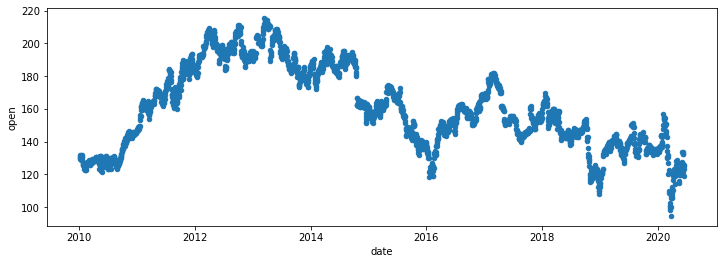

In [26]:
df.plot.scatter('date','open',figsize=(12,4))